In [4]:
import pandas as pd
import numpy as np
import glob, os  
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot
%matplotlib inline

In [5]:
inpath = "../data/epitope-predictions/predictions"
files = glob.glob(os.path.join(inpath, "*.csv"))

df = pd.concat((pd.read_csv(file, index_col=0, header=0) for file in files), ignore_index=True)

display(df)

,allele,ic50,name,peptide,pos,rank
0,HLA-A01:01,2037.05,AEN19369,ISDTSGFAVYV,192,1.0
1,HLA-A01:01,5141.57,AEN19369,LTVTIIRGHLY,144,2.0
2,HLA-A01:01,5166.82,AEN19369,FLDRISDTSGF,188,3.0
3,HLA-A01:01,5357.90,AEN19369,YGYTSRSMFVY,41,4.0
4,HLA-A01:01,5363.93,AEN19369,YIQGIKLGIGY,154,5.0
...,...,...,...,...,...,...
55811683,HLA-DRB113:01,43341.10,AEN19370,MDEPFTEDTSE,436,434.0
55811684,HLA-DRB113:01,43591.98,AEN19370,ADIVDRDPSSD,158,435.0
55811685,HLA-DRB113:01,43680.73,AEN19370,SGNPDEPQKDV,337,436.0
55811686,HLA-DRB113:01,45482.18,AEN19370,KDATKPQQVTK,245,437.0


In [6]:
df.groupby('name').size()

name
AAT98580     49802
AAT98583      2664
AAT98584      7881
AAT98585     15947
AAT98586      7215
             ...  
YP_173238    49802
YP_173240     2664
YP_173241     7881
YP_173242    15947
YP_173243     7215
Length: 3730, dtype: int64

In [7]:
# Concatenate allele-peptide combinations
df['allele-peptide'] = df['allele'] + "-" + df['peptide']

In [8]:
ap = df['allele-peptide'].value_counts()
ap = ap[ap.gt(3)]
df = df[df['allele-peptide'].isin(ap.index)]

In [9]:
df.loc[:,'ic50'] = 1/df['ic50']

pivoted = df.pivot_table('ic50', 'name', 'allele-peptide') 

pivoted = pivoted.fillna(0)
display(pivoted)

allele-peptide,HLA-A01:01-AAAGIPFSLNV,HLA-A01:01-AAAGVPFSLNV,HLA-A01:01-AAAGVPFYLNV,HLA-A01:01-AAAIPFSLALQ,HLA-A01:01-AAALKSLGFDK,HLA-A01:01-AAAYYVGYLQP,HLA-A01:01-AACHDLLSEYG,HLA-A01:01-AACKLQLVEYG,HLA-A01:01-AACKSQLVEYG,HLA-A01:01-AADLDDFSKQL,...,HLA-DRB115:01-YYVLPLTCNAI,HLA-DRB115:01-YYVMPLTCIAR,HLA-DRB115:01-YYVMPLTCIRR,HLA-DRB115:01-YYVMPLTCISR,HLA-DRB115:01-YYVMPLTCNAI,HLA-DRB115:01-YYVMPLTCNSK,HLA-DRB115:01-YYVSNGGNNCT,HLA-DRB115:01-YYVSNGSNNCT,HLA-DRB115:01-YYYPEPISDKN,HLA-DRB115:01-YYYPEPITENN
name,,,,,,,,,,,,,,,,,,,,,
AAT98580,0.000183,0.0,0.0,0.0,0.0,0.0,0.000184,0.0,0.0,0.0,...,0.000488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000064,0.0
AAT98583,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAT98584,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAT98585,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAT98586,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_173238,0.000183,0.0,0.0,0.0,0.0,0.0,0.000184,0.0,0.0,0.0,...,0.000488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000064,0.0
YP_173240,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
YP_173241,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [23]:
# Checkpoint the pivoted features to file
outpath = "../data/epitope-predictions/epitope-features.csv"
pivoted.to_csv(outpath, encoding='utf-8', index=False)

In [11]:
inpath = "../data/epitope_data/common_coronaviruses_and_sars2_M_E_N_Spike_parsed.csv"
lookup = pd.read_csv(inpath)
lookup = lookup.drop_duplicates(subset='Accession', keep='first', inplace=False)

merged = pd.DataFrame(pivoted.index).merge(lookup[['Accession', 'Protein_Type', 'Geo_Location', 'Species']], how='left', left_on='name', right_on='Accession')
merged = merged.set_index('name')
display(merged)

,Accession,Protein_Type,Geo_Location,Species
name,,,,
AAT98580,AAT98580,spike glycoprotein,NaN,Human coronavirus HKU1
AAT98583,AAT98583,small membrane protein,NaN,Human coronavirus HKU1
AAT98584,AAT98584,membrane glycoprotein,NaN,Human coronavirus HKU1
AAT98585,AAT98585,nucleocapsid phosphoprotein,NaN,Human coronavirus HKU1
AAT98586,AAT98586,nucleocapsid phosphoprotein 2,NaN,Human coronavirus HKU1
...,...,...,...,...
YP_173238,YP_173238,spike glycoprotein,NaN,Human coronavirus HKU1
YP_173240,YP_173240,small membrane protein,NaN,Human coronavirus HKU1
YP_173241,YP_173241,membrane glycoprotein,NaN,Human coronavirus HKU1


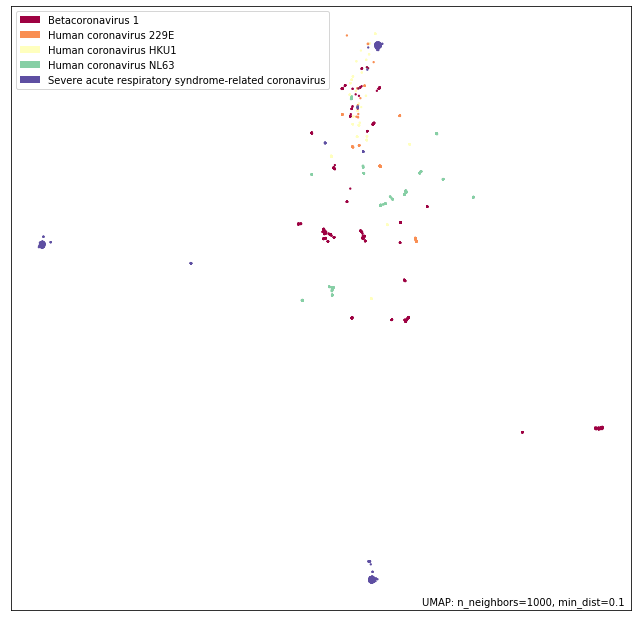

In [12]:
clustered = umap.UMAP(n_neighbors=1000,
                 min_dist=0.1).fit(pivoted)
umap.plot.points(clustered, labels=merged['Species'])

In [13]:
merged.groupby('Protein_Type').size().sort_values(ascending=False)

Protein_Type
envelope protein                                     583
nucleocapsid phosphoprotein                          492
membrane glycoprotein                                479
spike glycoprotein, partial                          372
spike protein, partial                               318
nucleocapsid protein                                 210
spike protein                                        189
membrane protein                                     185
nucleocapsid protein, partial                        150
spike glycoprotein                                   145
N protein                                            122
nucleoprotein                                         93
nucleocapsid phosphoprotein, partial                  77
envelope small membrane protein                       70
spike glycoprotein precursor, partial                 51
spike surface glycoprotein                            43
spike, partial                                        22
nucleocapsid, part

In [14]:
merged.groupby('Species').size().sort_values(ascending=False)

Species
Severe acute respiratory syndrome-related coronavirus    1498
Betacoronavirus 1                                        1167
Human coronavirus NL63                                    612
Human coronavirus HKU1                                    227
Human coronavirus 229E                                    226
dtype: int64

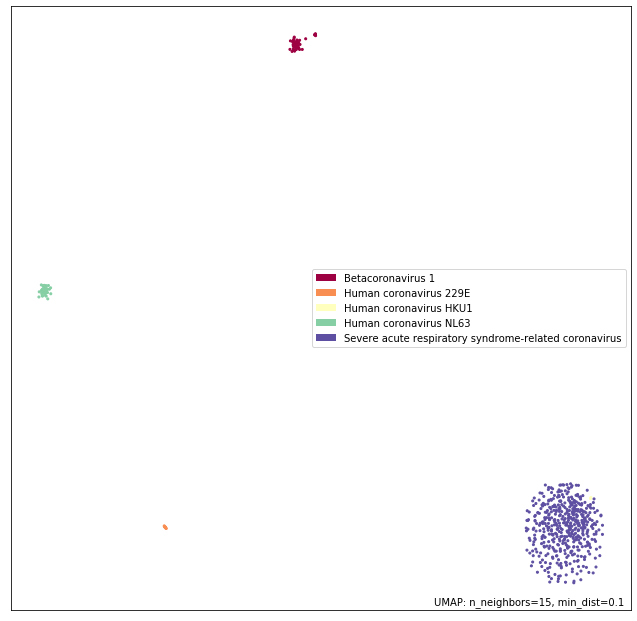

In [15]:
condition = merged['Protein_Type']=='envelope protein'

sample = pivoted[condition]
labels = merged[condition]

clustered1 = umap.UMAP(n_neighbors=15,
                 min_dist=0.1,
                 n_components=2,
                ).fit(sample)
umap.plot.points(clustered1, labels=labels['Species'])

In [16]:
labels.groupby('Species').size()

Species
Betacoronavirus 1                                         48
Human coronavirus 229E                                    11
Human coronavirus HKU1                                     2
Human coronavirus NL63                                    42
Severe acute respiratory syndrome-related coronavirus    480
dtype: int64

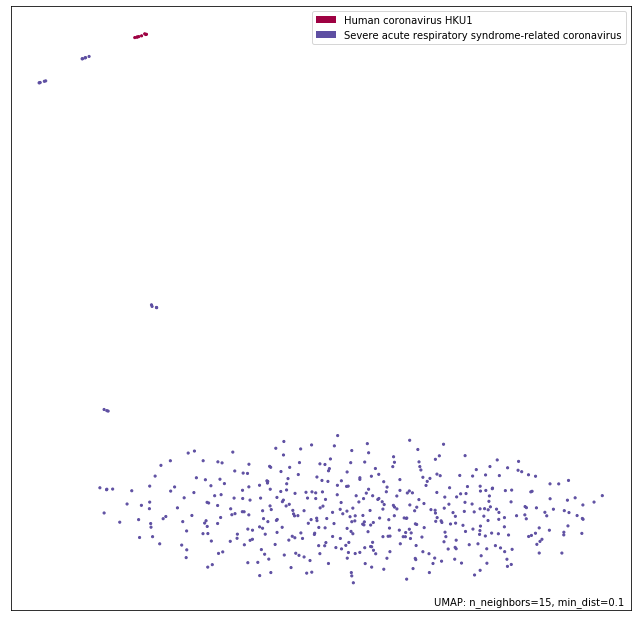

In [24]:
condition = merged['Protein_Type']=='membrane glycoprotein'

sample = pivoted[condition]
labels = merged[condition]

clustered2 = umap.UMAP(n_neighbors=15,
                 min_dist=0.1,
                 n_components=2,
                ).fit(sample)
umap.plot.points(clustered2, labels=labels['Species'])

In [18]:
labels.groupby('Species').size()

Species
Human coronavirus HKU1                                     7
Severe acute respiratory syndrome-related coronavirus    485
dtype: int64

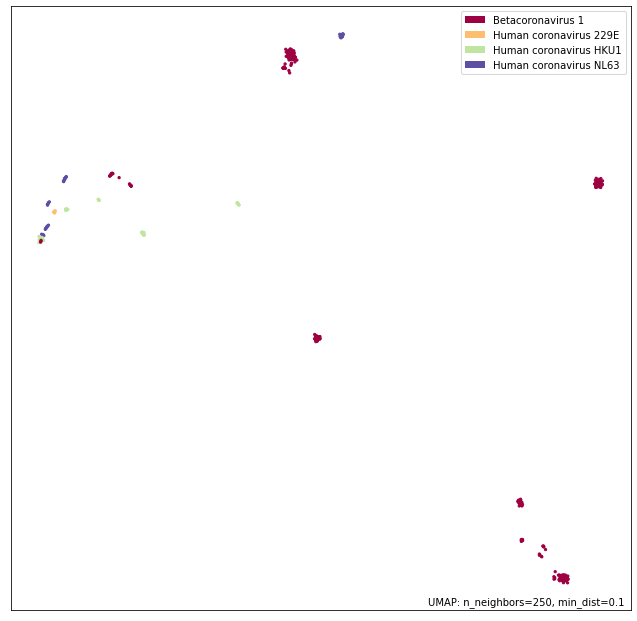

In [19]:
condition = merged['Protein_Type'].isin(['spike glycoprotein, partial'])

sample = pivoted[condition]
labels = merged[condition]

clustered3 = umap.UMAP(n_neighbors=250,
                 min_dist=0.1,
                 n_components=2,
                ).fit(sample)
umap.plot.points(clustered3, labels=labels['Species'])

In [20]:
labels.groupby('Species').size()

Species
Betacoronavirus 1         249
Human coronavirus 229E     10
Human coronavirus HKU1     60
Human coronavirus NL63     53
dtype: int64

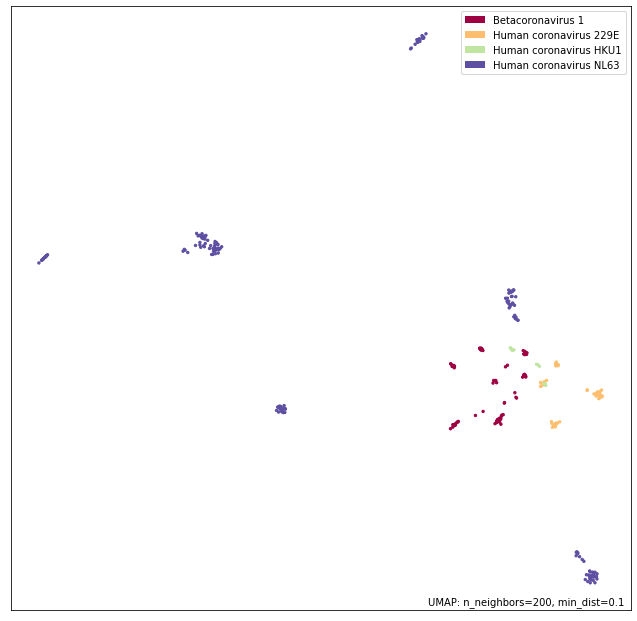

In [21]:
condition = merged['Protein_Type']=='spike protein, partial'

sample = pivoted[condition]
labels = merged[condition]

clustered3 = umap.UMAP(n_neighbors=200,
                 min_dist=0.1,
                 n_components=2,
                ).fit(sample)
umap.plot.points(clustered3, labels=labels['Species'])

In [22]:
labels.groupby('Species').size()

Species
Betacoronavirus 1          85
Human coronavirus 229E     51
Human coronavirus HKU1     11
Human coronavirus NL63    171
dtype: int64